# ToDo
- Uncertainty quantification
- Time series of different history

In [224]:
%matplotlib inline
import numpy as np
np.random.seed(42)

import tensorflow as tf
import matplotlib.pyplot as plt

from pandas import read_table
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, AveragePooling1D, Dropout, Flatten, GRU, LSTM
from keras.optimizers import *

In [225]:
filename = 'timeseries_data.csv'
df = read_table(filename, sep=',')
length = len(df)
dim = len(df.columns)

In [226]:
test_length = 9  # test on the last 9 months
train_length = length - test_length
ts = df.values
ts_train = ts[:train_length]

______
We could use stateful RNN. However, in practice, this is not preferred because:
- A long window is sufficient to capture any long-term dependency in the time series
- It's impossible to debug after live deployment because the series would grow indefinitely

So we will try two window-based approaches: temporal convolution and truncated RNN.

In [227]:
# Normalize data
means = ts[:train_length, :].mean(0)
stds = ts[:train_length, :].std(0)
ts_normed = (ts - means) / stds
assert ts_normed.shape == ts.shape and np.sum(np.isnan(ts_normed)) == 0

In [228]:
sequence_length = 20

# Generate X and y for train/test
# Xs are 3D tensors of shape number of sequences * sequence length * dim
# ys are 2D tensors of shape number of sequences * dim
X_train, y_train, X_test, y_test = [], [], [], []

for i in range(train_length - sequence_length):
    X_train.append(ts_normed[i:i+sequence_length])
    y_train.append(ts_normed[i+sequence_length])

for i in range(-test_length, 0):
    y_test.append(ts_normed[i])
    X_test.append(ts_normed[i-sequence_length:i])
    
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

def compute_mape(model, x, y):
    forecasts = model.predict(x, batch_size=len(x))
    forecasts = (forecasts * stds) + means
    y_denom = (y * stds) + means
    return np.mean(np.abs((y_denom - forecasts) / y_denom))
    
def test(model):
    print('Train Mean Absolute Percentage Error (MAPE): {0:.3f}'.format(compute_mape(model, X_train, y_train)))
    print('Test Mean Absolute Percentage Error (MAPE): {0:.3f}'.format(compute_mape(model, X_test, y_test)))

### Temporal Convolution

Creating Model
Training
Min. training loss: 0.055
Testing
Train Mean Absolute Percentage Error (MAPE): 0.121
Test Mean Absolute Percentage Error (MAPE): 0.145


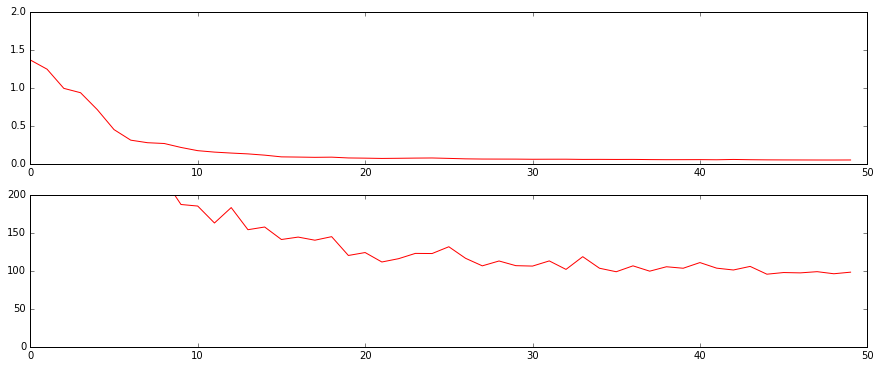

In [240]:
from keras.layers.advanced_activations import ELU
# Hyper parameters
n_layers = 1
activation = ELU()
batch_size = 8
epochs = 50

print('Creating Model')
sequence_input = Input(shape=(sequence_length, dim))
x = Conv1D(64, 5, activation=activation, init='glorot_normal')(sequence_input)
# dim: 16 x 64
x = MaxPooling1D(3, stride=1)(x)
# x = AveragePooling1D(pool_length=2, stride=1)(x)
# dim: 14 x 64
x = Conv1D(64, 3, activation=activation, init='glorot_normal')(x)
# dim: 12 x 64
x = MaxPooling1D(4, stride=2)(x)  # global max pooling
# x = AveragePooling1D(pool_length=4, stride=1)(x)
# dim: 5 x 64
x = Conv1D(128, 3, activation=activation, init='glorot_normal')(x)
# dim: 3 x 128
x = MaxPooling1D(3, stride=1)(x)  # global max pooling
# x = AveragePooling1D(pool_length=4, stride=1)(x)
# dim: 1 x 128
x = Flatten()(x)
x = Dense(128, activation=activation, init='glorot_normal')(x)
# x = Dropout(0.5)(x)
preds = Dense(dim)(x)
model = Model(sequence_input, preds)

# sgd = Nadam(lr=999, schedule_decay=0.1)
# sgd = Nadam(lr=0.1, schedule_decay=0.01)
# sgd = RMSprop(lr=0.1)
# sgd = SGD(lr=0.01, momentum=0.9, decay=0.1, nesterov=False)
# model.compile(loss='mape', optimizer=sgd, metrics=['mape'])
sgd = SGD(lr=0.1, momentum=0.9, decay=0.1, nesterov=False)
model.compile(loss='mse', optimizer=sgd, metrics=['mape'])

print('Training')
history = model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=epochs, 
                    verbose=0, validation_split=0.0)

plt.figure(figsize=(15,6))
plt.subplot(211)
plt.plot(history.epoch, history.history['loss'], 'r') 
# plt.plot(history.epoch, history.history['val_loss'], 'b')
plt.ylim(0, 2)
plt.subplot(212)
plt.plot(history.epoch, history.history['mean_absolute_percentage_error'], 'r')
#plt.plot(history.epoch, history.history['val_mean_absolute_percentage_error'], 'b')
plt.ylim(0, 200)

print('Min. training loss: {0:.3f}'.format(min(history.history['loss'])))
# print('Min. validation loss: {1:.3f}'.format(min(history.history['val_loss'])))
print('Testing')
test(model)

### RNN

Creating Model
Training
Min. training loss: 0.048
Testing
Train Mean Absolute Percentage Error (MAPE): 0.200
Test Mean Absolute Percentage Error (MAPE): 0.191


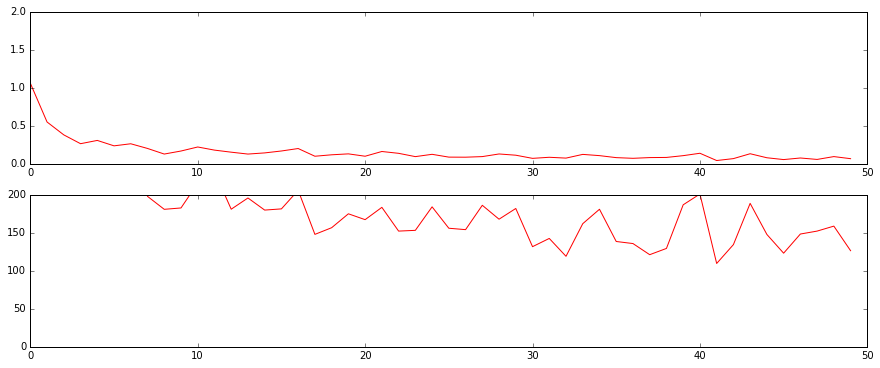

In [242]:
# Hyper parameters
num_rnn_layers = 1
num_rnn_units = 128
batch_size = 8
epochs = 50

print('Creating Model')
model = Sequential()
for i in range(num_rnn_layers):
    model.add(GRU(num_rnn_units, 
                  input_length=sequence_length, input_dim=dim,
                  return_sequences=True if i < num_rnn_layers-1 else False))
model.add(Dense(dim, init='glorot_normal'))
#sgd = SGD(lr=999999, decay=1e-4, nesterov=True)
#sgd = Nadam(lr=999, schedule_decay=0.1)
# sgd = Nadam(lr=0.01, schedule_decay=0.1)
# model.compile(loss='mape', optimizer=sgd, metrics=['mape', 'mse'])
# sgd = Nadam(lr=0.1, schedule_decay=1e-2)
# sgd = SGD(lr=0.01, momentum=0.5, decay=1e-3)
sgd = RMSprop(lr=0.01)
model.compile(loss='mse', optimizer=sgd, metrics=['mape'])

print('Training')
history = model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=epochs, 
                    verbose=0, validation_split=0.0)

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(211)
plt.plot(history.epoch, history.history['loss'], 'r') 
# plt.plot(history.epoch, history.history['val_loss'], 'b')
plt.ylim(0, 2)
plt.subplot(212)
plt.plot(history.epoch, history.history['mean_absolute_percentage_error'], 'r')
# plt.plot(history.epoch, history.history['val_mean_absolute_percentage_error'], 'b')
plt.ylim(0, 200)

print('Min. training loss: {0:.3f}'.format(min(history.history['loss'])))
# print('Min. validation loss: {1:.3f}'.format(min(history.history['val_loss'])))

print('Testing')
test(model)